###### Seyedali Shohadaeolhosseini ---- What doesn'y KILL you, makes you STRONGER

# Sentiment Analysis

    In this notebool we are going to implement an intelligent algorithm, which can analysis the sentiment of the given sentence. 
    We are going to use Logistic Regression as our classifier for Sentiment Analysis. The algorithm is goind to determine whether a tweet has a positive sentiment or negative. Logistic Regression is one the known algorithm that is being use in supervised classification problems.

Let's Start It.

## Step 1

In this we will import our required module and datasets.

In [30]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples

import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer


filePath = "D:\\My Works\\Projects\\AI Projects\\Project NLP Sentiment Analysis\\Datasets"
nltk.data.path.append(filePath)

### Step 1-1 - Data Preparation

Now Let's take a look at our datasets. The below pictures shows my directory containing our datasets

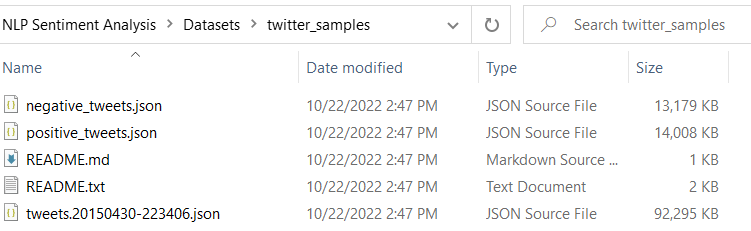


- We have imported `twitter_samples` in the last steps and in the next step we're going to import and assign a variable to it with the help of 
```python
twitter_samples.strings("name of the dataset")
```

method.

In [33]:
AllOf_Positive_TWT = twitter_samples.strings('positive_tweets.json')
AllOf_Negative_TWT = twitter_samples.strings('negative_tweets.json')

In [22]:
print("Negative Tweets:\n Number of data:", len(AllOf_Negative_TWT), "\n Sample: ", AllOf_Negative_TWT[0])
print("\n\nPositive Tweets:\n Number of data:", len(AllOf_Positive_TWT), "\n Sample: ", AllOf_Positive_TWT[0])

Negative Tweets:
 Number of data: 5000 
 Sample:  hopeless for tmr :(


Positive Tweets:
 Number of data: 5000 
 Sample:  #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)


- As you have noticed, we have up to 5000 data(Tweets) for each category. We use up to 20% of the data as our test data and we use the rest of the data to train the classifier.
- In the below cell we are doing this.
- After spliting the data to test and train, we mix the negative and positive data

In [24]:
test_pos = all_positive_tweets[4000:]  ## Last 20% per cent of the data - From 4000 to 5000 have been chosen as test data
test_neg = all_negative_tweets[4000:]  ## Last 20% per cent of the data - From 4000 to 5000 have been chosen as test data

train_pos = all_positive_tweets[:4000] ## The first 80% as train set
train_neg = all_negative_tweets[:4000] ## The first 80% as train set

train_x = train_pos + train_neg # Mixing data
test_x = test_pos + test_neg

- Now we must define our data's label ourself. To achieve this we assign value 0 to negative tweets and assign 1 to positive tweets.

- We use numpy module to create a M * 1 matrix, where M is the number of data and 1 referes to one column. We expect that the first 4000 data of the `train_pos` variables which are positive, take labels equal to 1 that is why we use `np.ones()`. Also, we expect the labels of the second 4000 data of the train sets get values 0 since they negative category.

Check out the below code

In [26]:
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


### Step 2
* Now to go further, we need have to a calculation on the frequency of the each words. We must calculate that, how many times the word has appeared in the negative and positive sentence. We need to construct a dictionary maping the `(word, label)` to `Number` where number is the occurrance of that word in that label(Positive Sentiment or negative sentiment).
* To achieve this, let's take a look at sample tweet: 

In [27]:
train_x[0]

'#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)'

* As you have noticed, these samples have redundant words in themself, which does not have any sentiment.
* So before caluculating the frequency, first we need to remove these redundants which are known as Stopwords and Some punctution.
* To achieve this we have a dataset, in which these stop words are determined, so we just write a function, which takes a tweet in input and process it and returns the word which has sentiment.

* The ` Process_Tweet` functino in the next cell do this for us.

In [28]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

- Let's Test the function and see an output of it:

In [34]:
print(train_x[0])
print(process_tweet(train_x[0]))

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


* Now we are ready to look for the number of occurance of each of these words in their defined sentiment
* The below method helps us with this:

In [35]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

* Now that we have implemented our two important functions, we are going to call them with train dataset as input, to get the frequency of each words in their context. 

In [36]:
freqs = build_freqs(train_x, train_y) ## freqs is a dictionary, mapping (word, label) to frequency

### Step 3 - Logistic Regression
- Now that we have our `frequency` and `train_x` and `train_y` we must go further to implement our classifier, which is a Logistic Regression here for Text classification.

- Logistic Regression uses sigmoid as its hypothesis function:

$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$
- The input if this function, scales to the (0, 1) range
- The next cell is its implementation:

In [37]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    h = 1 / (1 + (np.exp(-z)))
    return h

In [38]:
sigmoid(0)

0.5

- Logistic regression gives a regression equation to the sigmoid function, and the sigmoid predicts the label range based on the input data and parameters.

Regression:
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$


Logistic regression
$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

- Then we try to achieve to the best output by changing the parameters(theta)
- This also will be achieved with the help of Gradient Descent, an algorithm which helps us to achieve to the minimum cost
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))$$
    * $m$ is the number of training examples
    * $y^{(i)}$ is the actual label of the i-th training example.
    * $h(z(\theta)^{(i)})$ is the model's prediction for the i-th training example.
    
- We then update the parameters(theta) to achieve to a lower cost in:

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x_j $$
* 'i' is the index across all 'm' training examples.
* 'j' is the index of the weight $\theta_j$, so $x_j$ is the feature associated with weight $\theta_j$

* To update the weight $\theta_j$, we adjust it by subtracting a fraction of the gradient determined by $\alpha$:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
* The learning rate $\alpha$ is a value that we choose to control how big a single update will be.


----------------------

- If you can implement these theory more easily with the help of Matrixes and theirs Dot products rules.

$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$

$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$


- Our Gradient Descent would be:

In [39]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    # get 'm', the number of rows in matrix x
    m = len(x)
    
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x, theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = ((-1)/m) * (np.dot(np.transpose(y), np.log(h)) + (np.dot(np.transpose(np.subtract(1, y)), np.log(np.subtract(1, h)))))

        # update the weights theta
        theta = theta - ((alpha / m) * (np.dot(np.transpose(x), np.subtract(h, y))))
        
    J = float(J)
    return J, theta

* Each data(tweet) in Logistic Regression method, has three features: [bias PosFreq NegFreq] where `bias` equals to 1 and the `PosFreq` `NegFreq` eqauls to sum of the number of the occurrance of the tweet's word in the Positive Sentiment and Negative Sentiment, respectively. We have totally overviewed and construct of freqeuncy of words in real words, and here we use them to assign their value.
- our feature extraction would like some below:

In [41]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
    
    # loop through each word in the list of words
    for word in word_l:
        
        try:
        # increment the word count for the positive label 1
            x[0,1] += freqs[word, 1.0]
        except: ...
            
        try:
        # increment the word count for the negative label 0
            x[0,2] += freqs[word, 0.0]
        except: ...
        
    assert(x.shape == (1, 3))
    return x

### Step 4 
- Now that we have our features, datasets, and algorithm ready, we can start training our model.
- To achieve this in its easiest form, we use matrixes

In [58]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3)) ## M * 3 matrix, where M is the number of data and 3 is the number of our features
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs) ## [[bias PosFreq NegFreq], ... ] for each tweet

# training labels corresponding to X
Y = train_y

## Theta in the first run equals to zero, then it exprience update
# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1000) ## Increase the iteration to achieve to a better model
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.29484167.
The resulting vector of weights is [5e-08, 0.00040058, -0.00045067]


- Now that we have trained our model, we reach to the best theta which has only 14 per cent cost. We use this theta values along with sigmoid function to predict the tweets' sentiment. 
- Below function does this
- This funciton, at the first steps, extracts the tweets features, the polarity of being Positive or Negative
- Then it uses sigmoid function along with the achieved theta to predict.

In [59]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))

    
    return y_pred

Let's test our model with a couple of handmade data:

In [60]:
ex_tweet = ["I am a good Person. .......", "you are a BAD PERSON", "Hey! What ya doin? ...", "This was good", "We reached to the end of this notebook00 :)))))))))))))))"]

for twt in ex_tweet:
    print(f"{process_tweet(twt)} = Polarity: {predict_tweet(twt, freqs, theta)}")

['good', 'person', '. ...'] = Polarity: [[0.50948736]]
['bad', 'person'] = Polarity: [[0.49514287]]
['hey', 'ya', 'doin', '...'] = Polarity: [[0.49515457]]
['good'] = Polarity: [[0.50977523]]
['reach', 'end', 'notebook', '00', ':)'] = Polarity: [[0.75546813]]


Nice, Yes ? :))

### Accuracy checking
- In this step we use our test data to check the accuracy of our model and parameters
- Below code does that:



In [61]:
def test_model(test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1)
        else:
            # append 0 to the list
            ...

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = (len(y_hat) / len(test_y[0]))
    
    return accuracy

In [63]:
acc = test_model(test_x, test_y, freqs, theta)
acc

992.0

## __`Done! :)`__